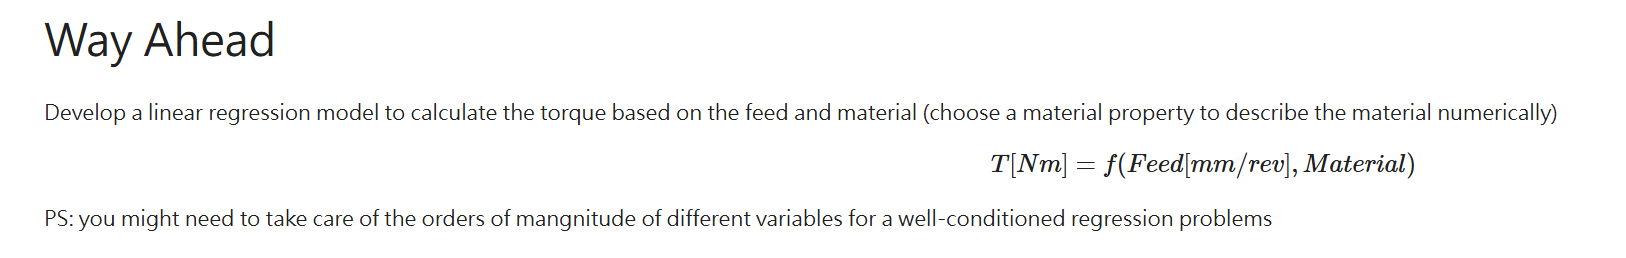

In [21]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [22]:
df = pd.read_csv('XAI_Drilling_Dataset.csv')

## Data

Material

| Material Code | Material Description                                      | Young's Modulus (GPa) | Poisson's Ratio | Hardness (Brinell) |
|---------------|-----------------------------------------------------------|------------------------|------------------|---------------------|
| N             | Aluminum-silicon (AlSi) alloy (EN AC-42000)           | 70                     | 0.33             | 70                  |
| P             | C45K hot-rolled heat-treatable steel (EN 1.0503)        | 190                    | 0.29             | 180                 |
| K             | Cast iron GJL (EN GJL-250)                               | 124                    | 0.26             | 160                 |

In [23]:
material_props = {
    'N': {'Name': 'AlSi alloy', 'Young\'s Modulus [GPa]': 70, 'Poisson\'s Ratio': 0.33, 'Hardness [Brinell]': 70},
    'P': {'Name': 'C45K steel', 'Young\'s Modulus [GPa]': 190, 'Poisson\'s Ratio': 0.29, 'Hardness [Brinell]': 180},
    'K': {'Name': 'Cast iron', 'Young\'s Modulus [GPa]': 124, 'Poisson\'s Ratio': 0.26, 'Hardness [Brinell]': 160}
}

In [24]:
# form "XAI_Drilling_Dataset.html"
df = pd.read_csv("XAI_Drilling_Dataset.csv", index_col=0)
df["Torque T [Nm]"] = df["Power Pc [kW]"] * 1000 / (df["Spindle speed n [1/min]"] * np.pi / 30)

df["Hardness [Brinell]"] = df["Material"].map(lambda x: material_props[x]["Hardness [Brinell]"])
df["Young's Modulus [GPa]"] = df["Material"].map(lambda x: material_props[x]["Young\'s Modulus [GPa]"])
df["Poisson's Ratio"] = df["Material"].map(lambda x: material_props[x]["Poisson\'s Ratio"])

##  Linear Regression Model

This code performs linear regression to predict Torque [Nm] using standardized material and process features.


**Standardized Model** (after applying `StandardScaler`)
- Standardization:
  $$
  z_i = \frac{x_i - \mu_i}{\sigma_i}
  $$
- Model form:
  $$
  \text{Torque} = b + w_1 \cdot z_1 + w_2 \cdot z_2 + \dots
  $$

---

**Original Units**
- Original input format:
  $$
  \text{Torque} = a + c_1 \cdot x_1 + c_2 \cdot x_2 + \dots
  $$

- Conversion Rules:
  * Recovered Coefficients:
    $$
    c_i = \frac{w_i}{\sigma_i}
    $$
  * Recovered Intercept:
    $$
    a = b - \sum \frac{w_i \cdot \mu_i}{\sigma_i}
    $$

### Linear Regression Analysis Using One Material Property

In [25]:
# choose a material property
feature_sets = [
    ["Feed f [mm/rev]", "Hardness [Brinell]"],
    ["Feed f [mm/rev]", "Young's Modulus [GPa]"],
    ["Feed f [mm/rev]", "Poisson's Ratio"]
]

for feats in feature_sets:
    X_raw = df[feats]
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)
    y = df["Torque T [Nm]"]

    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)

    formula = f"Torque [Nm] = {model.intercept_:.2f}"
    for name, coef in zip(feats, model.coef_):
        formula += f" + {coef:.2f} × {name} (z-score)"

    real_coefs = model.coef_ / scaler.scale_
    real_intercept = model.intercept_ - np.sum(model.coef_ * scaler.mean_ / scaler.scale_)

    real_formula = f"Torque [Nm] = {real_intercept:.2f}"
    for name, coef in zip(feats, real_coefs):
        real_formula += f" + {coef:.2f} × {name}"

    print(f"Features: {', '.join(feats)}")
    print(f"R^2: {r2:.4f}")
    print("(Standardized)", formula)
    print(real_formula, "\n")

Features: Feed f [mm/rev], Hardness [Brinell]
R^2: 0.8925
(Standardized) Torque [Nm] = 1888.55 + 87.84 × Feed f [mm/rev] (z-score) + -477.12 × Hardness [Brinell] (z-score)
Torque [Nm] = 2727.15 + 2338.64 × Feed f [mm/rev] + -9.98 × Hardness [Brinell] 

Features: Feed f [mm/rev], Young's Modulus [GPa]
R^2: 0.6813
(Standardized) Torque [Nm] = 1888.55 + -28.43 × Feed f [mm/rev] (z-score) + -477.21 × Young's Modulus [GPa] (z-score)
Torque [Nm] = 3304.41 + -756.90 × Feed f [mm/rev] + -9.73 × Young's Modulus [GPa] 

Features: Feed f [mm/rev], Poisson's Ratio
R^2: 0.9935
(Standardized) Torque [Nm] = 1888.55 + 321.92 × Feed f [mm/rev] (z-score) + 458.19 × Poisson's Ratio (z-score)
Torque [Nm] = -4726.53 + 8570.38 × Feed f [mm/rev] + 15984.66 × Poisson's Ratio 



| Feature Set            | R²     | Standardized Coefficients (Feed / Material) | Unstandardized Coefficients (Feed / Material) | Intercept | Comments                                                                                                                     |
| ---------------------- | ------ | ------------------------------------------- | --------------------------------------------- | --------- | ---------------------------------------------------------------------------------------------------------------------------- |
| (**V**) Feed + Hardness     | 0.8925 | +87.84 / −477.12                            | +2338.64 / −9.98                              | +2727.15  | **Stable** model with good accuracy and interpretable coefficients                          |
| Feed + Young's Modulus | 0.6813 | −28.43 / −477.21                            | −756.90 / −9.73                               | +3304.41  | Low R^2                                          |
| Feed + Poisson’s Ratio | 0.9935 | +321.92 / +458.19                           | +8570.38 / +15984.66                          | −4726.53  | High R² but **very large coefficients**. May indicate overfitting or sensitivity to input noise |



### Time Feature Testing

In [26]:
#process time

feature_sets = [
    ["Feed f [mm/rev]", "Hardness [Brinell]", "Process Time [sec]"],
    ["Feed f [mm/rev]", "Process Time [sec]"],
    ["Feed rate vf [mm/min]", "Process Time [sec]"],
    ["Hardness [Brinell]", "Process Time [sec]"]
]

for feats in feature_sets:
    X_raw = df[feats]
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)
    y = df["Torque T [Nm]"]

    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)

    formula = f"Torque [Nm] = {model.intercept_:.2f}"
    for name, coef in zip(feats, model.coef_):
        formula += f" + {coef:.2f} × {name} (z-score)"

    real_coefs = model.coef_ / scaler.scale_
    real_intercept = model.intercept_ - np.sum(model.coef_ * scaler.mean_ / scaler.scale_)

    real_formula = f"Torque [Nm] = {real_intercept:.2f}"
    for name, coef in zip(feats, real_coefs):
        real_formula += f" + {coef:.2f} × {name}"

    print(f"Features: {', '.join(feats)}")
    print(f"R^2: {r2:.4f}")
    print("(Standardized)", formula)
    print(real_formula, "\n")

Features: Feed f [mm/rev], Hardness [Brinell], Process Time [sec]
R^2: 0.8970
(Standardized) Torque [Nm] = 1888.55 + 99.21 × Feed f [mm/rev] (z-score) + -222.45 × Hardness [Brinell] (z-score) + -252.37 × Process Time [sec] (z-score)
Torque [Nm] = 3005.65 + 2641.21 × Feed f [mm/rev] + -4.65 × Hardness [Brinell] + -36.75 × Process Time [sec] 

Features: Feed f [mm/rev], Process Time [sec]
R^2: 0.8936
(Standardized) Torque [Nm] = 1888.55 + 111.61 × Feed f [mm/rev] (z-score) + -466.96 × Process Time [sec] (z-score)
Torque [Nm] = 3209.16 + 2971.44 × Feed f [mm/rev] + -68.01 × Process Time [sec] 

Features: Feed rate vf [mm/min], Process Time [sec]
R^2: 0.9685
(Standardized) Torque [Nm] = 1888.55 + 493.52 × Feed rate vf [mm/min] (z-score) + -55.54 × Process Time [sec] (z-score)
Torque [Nm] = 451.46 + 11.90 × Feed rate vf [mm/min] + -8.09 × Process Time [sec] 

Features: Hardness [Brinell], Process Time [sec]
R^2: 0.8735
(Standardized) Torque [Nm] = 1888.55 + -416.51 × Hardness [Brinell] (z-s

In [27]:
# time-per-depth
# According to the dataset paper, each hole has a fixed depth of 60 mm

df["Time_per_depth"] = df["Process Time [sec]"] / 60  # [sec/mm]

# Estimate drilling depth and compute time per depth
df["Estimated_Depth"] = df["Feed rate vf [mm/min]"] * df["Process Time [sec]"] / 60
df["Time_per_depth"] = df["Process Time [sec]"] / df["Estimated_Depth"]

feature_sets = [
   ["Feed f [mm/rev]", "Hardness [Brinell]", "Time_per_depth"]

]

for feats in feature_sets:
    X_raw = df[feats]
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)
    y = df["Torque T [Nm]"]

    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)

    formula = f"Torque [Nm] = {model.intercept_:.2f}"
    for name, coef in zip(feats, model.coef_):
        formula += f" + {coef:.2f} × {name} (z-score)"

    real_coefs = model.coef_ / scaler.scale_
    real_intercept = model.intercept_ - np.sum(model.coef_ * scaler.mean_ / scaler.scale_)

    real_formula = f"Torque [Nm] = {real_intercept:.2f}"
    for name, coef in zip(feats, real_coefs):
        real_formula += f" + {coef:.2f} × {name}"

    print(f"Features: {', '.join(feats)}")
    print(f"R^2: {r2:.4f}")
    print("(Standardized)", formula)
    print(real_formula, "\n")

Features: Feed f [mm/rev], Hardness [Brinell], Time_per_depth
R^2: 0.9483
(Standardized) Torque [Nm] = 1888.55 + 9.42 × Feed f [mm/rev] (z-score) + -203.98 × Hardness [Brinell] (z-score) + -343.20 × Time_per_depth (z-score)
Torque [Nm] = 3730.72 + 250.88 × Feed f [mm/rev] + -4.27 × Hardness [Brinell] + -2851.57 × Time_per_depth 

